# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [ ]:
!conda install -c pyviz hvplot geoviews
!pip install census
!pip install citipy

In [2]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests

# Import API key
from api_keys import geoapify_key

from requests.structures import CaseInsensitiveDict

In [3]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data/cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,bethel,41.3712,-73.4140,17.05,89,100,4.12,US,1712892966
1,1,port lincoln,-34.7333,135.8667,16.44,57,32,4.48,AU,1712892819
2,2,stanley,54.8680,-1.6985,11.01,86,75,4.63,GB,1712892817
3,3,albany,42.6001,-73.9662,15.85,82,100,3.58,US,1712892816
4,4,grytviken,-54.2811,-36.5092,-0.71,74,25,4.64,GS,1712893037


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

In [4]:
%%capture --no-display

# Plot the map with points sized by humidity
map_plot = city_data_df.hvplot.scatter(
    x='Lng',
    y='Lat',
    geo=True,
    tiles='CartoLight',
    title='City Locations with Humidity',
    hover_cols=['City', 'Country', 'Humidity'],  # Include 'Humidity' in hover information
    size='Humidity',  # Use 'Humidity' column to determine point size
    color='blue',  # Set color of points
    alpha=0.7,  # Set transparency of points
    width=800,  # Set width of the plot
    height=500  # Set height of the plot
)

# Save the plot as a PNG image
map_plot.save('city_locations_with_humidity.png')

# Display the plot inline
map_plot

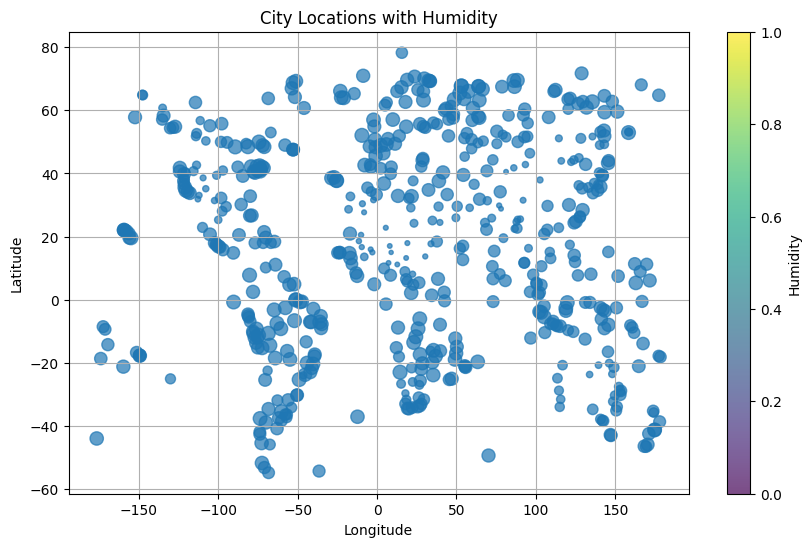

In [13]:
# Plot the data using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(city_data_df['Lng'], city_data_df['Lat'], s=city_data_df['Humidity'], alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City Locations with Humidity')
plt.grid(True)
plt.colorbar(label='Humidity')

# Save the plot as a PNG image
plt.savefig('city_locations_with_humidity.png')

# Show the plot
plt.show()


In [5]:
%%capture --no-display
# Plot the map with points sized by humidity using Datashader
map_plot = city_data_df.hvplot.scatter(
    x='Lng',
    y='Lat',
    geo=True,
    tiles='CartoLight',
    title='City Locations with Humidity',
    hover_cols=['City', 'Country', 'Humidity'],  # Include 'Humidity' in hover information
    size='Humidity',  # Use 'Humidity' column to determine point size
    color='blue',  # Set color of points
    alpha=0.7,  # Set transparency of points
    width=800,  # Set width of the plot
    height=500,  # Set height of the plot
    datashade=True  # Enable Datashader
)

# Save the plot as a PNG image
map_plot.save('city_locations_with_humidity.png')

# Display the plot inline
map_plot


KeyboardInterrupt: 

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [9]:
# Narrow down cities that fit criteria
# ideal_cities_df = city_data_df[(city_data_df['Max Temp'] >= 10) & (city_data_df['Max Temp'] < 27) 
# & (city_data_df['Wind Speed'] < 10) & (city_data_df['Humidity'] >= 30) & (city_data_df['Humidity'] < 61) ]

ideal_cities_df = city_data_df[city_data_df['Cloudiness'] == 0]


# Drop any rows with null values
# ideal_cities_df = ideal_cities_df.dropna()

# Display sample data
ideal_cities_df.head()


,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
14,14,carnarvon,-24.8667,113.6333,26.44,47,0,3.20,AU,1712892857
37,37,grants,35.1473,-107.8514,11.13,20,0,2.57,US,1712893086
59,59,susanville,40.4163,-120.6530,13.91,38,0,2.57,US,1712893061
61,61,calama,-22.4667,-68.9333,11.27,43,0,3.09,CL,1712893090
68,68,haiku-pauwela,20.9219,-156.3051,24.47,80,0,2.57,US,1712892798


### Step 3: Create a new DataFrame called `hotel_df`.

In [10]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
# copy of filterecities_df_copy
hotel_df = ideal_cities_df[['City', 'Country', 'Lat', 'Lng', 'Humidity']].copy()

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df["Hotel Name"] = ""

# Display sample data
hotel_df.head()

,City,Country,Lat,Lng,Humidity,Hotel Name
14,carnarvon,AU,-24.8667,113.6333,47,
37,grants,US,35.1473,-107.8514,20,
59,susanville,US,40.4163,-120.6530,38,
61,calama,CL,-22.4667,-68.9333,43,
68,haiku-pauwela,US,20.9219,-156.3051,80,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [47]:
# Set parameters for the hotel search
radius = 10000 
categories = "catering.restaurant"
limit = 1

# Set up the base URL for the API request
base_url = "https://api.geoapify.com/v2/places"

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # Get latitude and longitude from the DataFrame
    lat = row['Lat']
    lng = row['Lng']
    
    # Set filter and bias parameters with the current city's latitude and longitude
    filters = f"circle:{lng},{lat},{radius}"
    bias = f"proximity:{lng},{lat}"
    
    # Set up parameters dictionary
    params = {
        "categories": categories,
        "limit": limit,
        "filter": filters,
        "bias": bias,
        "apiKey": geoapify_key
    }
    
    # Make an API request using the params dictionary
    response = requests.get(base_url, params=params)

    # Convert the API response to JSON format
    name_address = response.json()
    
    # Extract hotel names from the response
    try:
        hotel_names = [feature["properties"]["name"] for feature in name_address["features"]]
        if hotel_names:
            hotel_df.loc[index, "Hotel Name"] = ", ".join(hotel_names)
        else:
            hotel_df.loc[index, "Hotel Name"] = "No hotel found"
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df.head(15)


carnarvon - nearest hotel: Noodle Sushi
grants - nearest hotel: Pizza Hut
susanville - nearest hotel: Young Sing
calama - nearest hotel: Donde Atilio
haiku-pauwela - nearest hotel: Nuka
tsarevo - nearest hotel: No hotel found
orkney - nearest hotel: No hotel found
emerald - nearest hotel: Lucky Wok
ushuaia - nearest hotel: Kalma Restó
prince rupert - nearest hotel: Dolly's Fish Market Restaurant
ancud - nearest hotel: La Casa Growler & Restobar
talara - nearest hotel: Huarique Black Pepe
woolgoolga - nearest hotel: Blue Elephant
st. john's - nearest hotel: No.4 Restaurant & Bar
dickinson - nearest hotel: Bonnie's Donut
ploudalmezeau - nearest hotel: Le Château d'Eau, Restaurant Panoramique (bar, crêperie, glacier)
salinas - nearest hotel: XL Grindhouse
eten - nearest hotel: No hotel found
saint-pierre - nearest hotel: Le Binôme
karratha - nearest hotel: Luce Bar e Cibo
charters towers - nearest hotel: Golden Mine
benghazi - nearest hotel: مطعم احميدة فاصوليا
bandar-e genaveh - nearest 

,City,Country,Lat,Lng,Humidity,Hotel Name
14,carnarvon,AU,-24.8667,113.6333,47,Noodle Sushi
37,grants,US,35.1473,-107.8514,20,Pizza Hut
59,susanville,US,40.4163,-120.6530,38,Young Sing
61,calama,CL,-22.4667,-68.9333,43,Donde Atilio
68,haiku-pauwela,US,20.9219,-156.3051,80,Nuka
70,tsarevo,BG,42.1667,27.8500,66,No hotel found
71,orkney,ZA,-26.9802,26.6727,39,No hotel found
84,emerald,AU,-23.5333,148.1667,27,Lucky Wok
90,ushuaia,AR,-54.8000,-68.3000,71,Kalma Restó
98,prince rupert,CA,54.3161,-130.3201,66,Dolly's Fish Market Restaurant


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

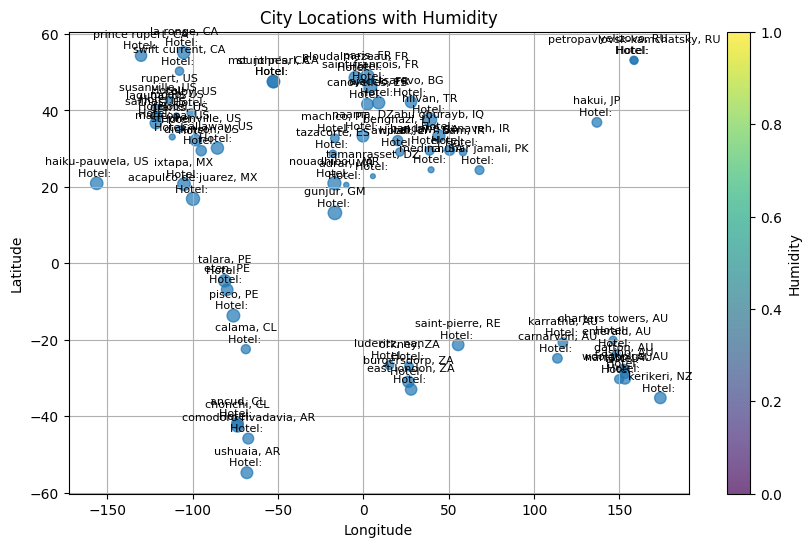

In [14]:
# Plot the data using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(hotel_df['Lng'], hotel_df['Lat'], s=hotel_df['Humidity'], alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City Locations with Humidity')
plt.grid(True)
plt.colorbar(label='Humidity')

# Add hotel name and country as additional information in the hover message
for index, row in hotel_df.iterrows():
    plt.annotate(f"{row['City']}, {row['Country']}\nHotel: {row['Hotel Name']}",
                 (row['Lng'], row['Lat']),
                 fontsize=8,
                 ha='center',
                 xytext=(0, 5),
                 textcoords='offset points')

# Save the plot as a PNG image
plt.savefig('city_locations_with_humidity.png')

# Show the plot
plt.show()
